<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
import random
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    

In [ ]:
def get_dataloader(image_size, batch_size, device):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """

    train_ds = ImageFolder('./images/', transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

    train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
    return train_ds, DeviceDataLoader(train_dl, device)

In [ ]:
image_size = 128
batch_size = 16

train_dataset, train_loader = get_dataloader(image_size, batch_size, device)

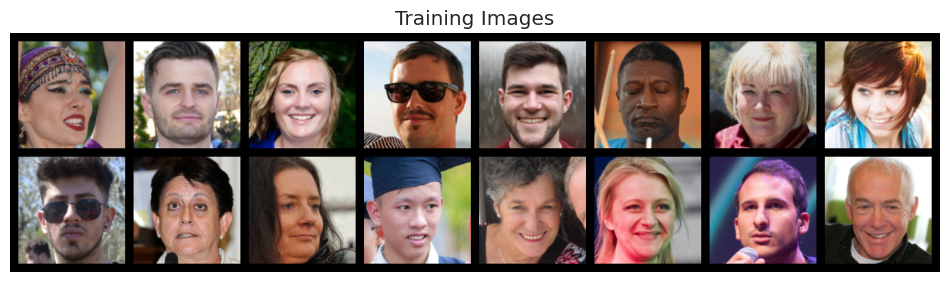

In [ ]:
first_batch = next(iter(train_loader))
plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(first_batch[0][:64], padding=10, normalize=True).cpu(), (1, 2, 0)));

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
# Возьмем за основу DCGAN из https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

num_channels = 3
discriminator_feature_maps = 32
generator_feature_maps = 64

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
discriminator = nn.Sequential(
    # input is num_channels x 128 x 128
    nn.Conv2d(num_channels, discriminator_feature_maps, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),

    # state size. discriminator_feature_maps x 64 x 64
    nn.Conv2d(discriminator_feature_maps, discriminator_feature_maps * 2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(discriminator_feature_maps * 2),
    nn.LeakyReLU(0.2, inplace=True),

    # state size. (discriminator_feature_maps * 2) x 32 x 32
    nn.Conv2d(discriminator_feature_maps * 2, discriminator_feature_maps * 4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(discriminator_feature_maps * 4),
    nn.LeakyReLU(0.2, inplace=True),

    # state size. (discriminator_feature_maps * 4) x 16 x 16
    nn.Conv2d(discriminator_feature_maps * 4, discriminator_feature_maps * 8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(discriminator_feature_maps * 8),
    nn.LeakyReLU(0.2, inplace=True),

    # state size. (discriminator_feature_maps * 8) x 8 x 8
    nn.Conv2d(discriminator_feature_maps * 8, discriminator_feature_maps * 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(discriminator_feature_maps * 16),
    nn.LeakyReLU(0.2, inplace=True),

    # state size. (discriminator_feature_maps * 16) x 4 x 4
    nn.Conv2d(discriminator_feature_maps * 16, 1, kernel_size=4, stride=1, padding=0, bias=False),

    # state size. 1 x 1 x 1
    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
discriminator.to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
discriminator.apply(weights_init)

# Print the model
print(discriminator)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [ ]:
latent_size = 128

generator = nn.Sequential(
    # input is latent_size, going into a convolution
    nn.ConvTranspose2d(latent_size, generator_feature_maps * 16, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(generator_feature_maps * 16),
    nn.ReLU(True),

    # state size. (generator_feature_maps * 16) x 4 x 4
    nn.ConvTranspose2d(generator_feature_maps * 16, generator_feature_maps * 8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(generator_feature_maps * 8),
    nn.ReLU(True),

    # state size. (generator_feature_maps * 8) x 8 x 8
    nn.ConvTranspose2d(generator_feature_maps * 8, generator_feature_maps * 4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(generator_feature_maps * 4),
    nn.ReLU(True),

    # state size. (generator_feature_maps * 4) x 16 x 16
    nn.ConvTranspose2d(generator_feature_maps * 4, generator_feature_maps * 2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(generator_feature_maps * 2),
    nn.ReLU(True),

    # state size. (generator_feature_maps * 2) x 32 x 32
    nn.ConvTranspose2d(generator_feature_maps * 2, generator_feature_maps, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(generator_feature_maps),
    nn.ReLU(True),

    # state size. generator_feature_maps x 64 x 64
    nn.ConvTranspose2d(generator_feature_maps, num_channels, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # state size. num_channels x 64 x 64
)

In [ ]:
generator.to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
generator.apply(weights_init)

# Print the model
print(generator)

Sequential(
  (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
lr = 0.0002
max_epochs = 50

model = {
    "discriminator": discriminator,
    "generator": generator
}

optimizer = {
    "discriminator": optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999)),
    "generator": optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [ ]:
def fit(train_dl, model, optimizer, criterion, epochs):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()
            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch + 1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
losses_g, losses_d, real_scores, fake_scores = fit(train_loader, model, optimizer, criterion, max_epochs)

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 14.9367, loss_d: 0.9483, real_score: 0.8409, fake_score: 0.1890


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 3.8940, loss_d: 1.0420, real_score: 0.7101, fake_score: 0.2716


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 3.1959, loss_d: 1.0901, real_score: 0.6844, fake_score: 0.3064


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 2.6857, loss_d: 1.0438, real_score: 0.6798, fake_score: 0.3154


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 2.7718, loss_d: 1.0697, real_score: 0.6682, fake_score: 0.3259


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 2.5675, loss_d: 1.0457, real_score: 0.6693, fake_score: 0.3247


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 2.7190, loss_d: 1.0660, real_score: 0.6640, fake_score: 0.3327


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 2.8315, loss_d: 0.9771, real_score: 0.6896, fake_score: 0.3073


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 2.3683, loss_d: 1.1823, real_score: 0.6331, fake_score: 0.3641


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 2.4059, loss_d: 1.0687, real_score: 0.6554, fake_score: 0.3399


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 2.3055, loss_d: 1.1022, real_score: 0.6477, fake_score: 0.3515


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 2.4967, loss_d: 1.0076, real_score: 0.6689, fake_score: 0.3295


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 2.6932, loss_d: 0.9344, real_score: 0.6914, fake_score: 0.3039


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 2.7604, loss_d: 0.9846, real_score: 0.6822, fake_score: 0.3144


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 2.8041, loss_d: 0.9196, real_score: 0.6976, fake_score: 0.3002


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 2.8116, loss_d: 0.9197, real_score: 0.6980, fake_score: 0.3001


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 2.9175, loss_d: 0.9245, real_score: 0.6978, fake_score: 0.2997


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 2.8556, loss_d: 0.9159, real_score: 0.7039, fake_score: 0.2972


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 2.7783, loss_d: 0.9013, real_score: 0.7049, fake_score: 0.2918


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 2.9302, loss_d: 0.8712, real_score: 0.7142, fake_score: 0.2843


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 2.8677, loss_d: 0.8652, real_score: 0.7166, fake_score: 0.2808


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 2.8191, loss_d: 0.8671, real_score: 0.7129, fake_score: 0.2863


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 2.9099, loss_d: 0.8117, real_score: 0.7291, fake_score: 0.2687


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 2.9539, loss_d: 0.7974, real_score: 0.7297, fake_score: 0.2664


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 2.9139, loss_d: 0.8242, real_score: 0.7310, fake_score: 0.2696


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 2.8355, loss_d: 0.7785, real_score: 0.7375, fake_score: 0.2617


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 2.8340, loss_d: 0.7689, real_score: 0.7417, fake_score: 0.2560


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 2.7776, loss_d: 0.7208, real_score: 0.7511, fake_score: 0.2478


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 2.7766, loss_d: 0.7472, real_score: 0.7490, fake_score: 0.2510


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 2.8047, loss_d: 0.6962, real_score: 0.7586, fake_score: 0.2375


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 2.8769, loss_d: 0.7249, real_score: 0.7573, fake_score: 0.2434


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 2.8963, loss_d: 0.6949, real_score: 0.7647, fake_score: 0.2322


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 2.9086, loss_d: 0.6545, real_score: 0.7740, fake_score: 0.2255


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 2.8798, loss_d: 0.7149, real_score: 0.7655, fake_score: 0.2338


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 2.8571, loss_d: 0.6137, real_score: 0.7821, fake_score: 0.2154


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 2.9498, loss_d: 0.6254, real_score: 0.7862, fake_score: 0.2119


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 3.0166, loss_d: 0.6123, real_score: 0.7894, fake_score: 0.2107


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 3.0566, loss_d: 0.5835, real_score: 0.7971, fake_score: 0.2002


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 3.0360, loss_d: 0.5353, real_score: 0.8114, fake_score: 0.1878


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 3.2045, loss_d: 0.5501, real_score: 0.8100, fake_score: 0.1904


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 3.1970, loss_d: 0.4971, real_score: 0.8229, fake_score: 0.1765


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 3.3131, loss_d: 0.5560, real_score: 0.8131, fake_score: 0.1844


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 3.2694, loss_d: 0.4854, real_score: 0.8280, fake_score: 0.1719


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 3.4245, loss_d: 0.5342, real_score: 0.8259, fake_score: 0.1735


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 3.4087, loss_d: 0.4463, real_score: 0.8385, fake_score: 0.1588


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 3.4253, loss_d: 0.4825, real_score: 0.8342, fake_score: 0.1648


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 3.4833, loss_d: 0.4484, real_score: 0.8433, fake_score: 0.1574


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 3.5602, loss_d: 0.3848, real_score: 0.8587, fake_score: 0.1407


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 3.5335, loss_d: 0.4228, real_score: 0.8492, fake_score: 0.1488


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 3.6893, loss_d: 0.4584, real_score: 0.8450, fake_score: 0.1552


Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

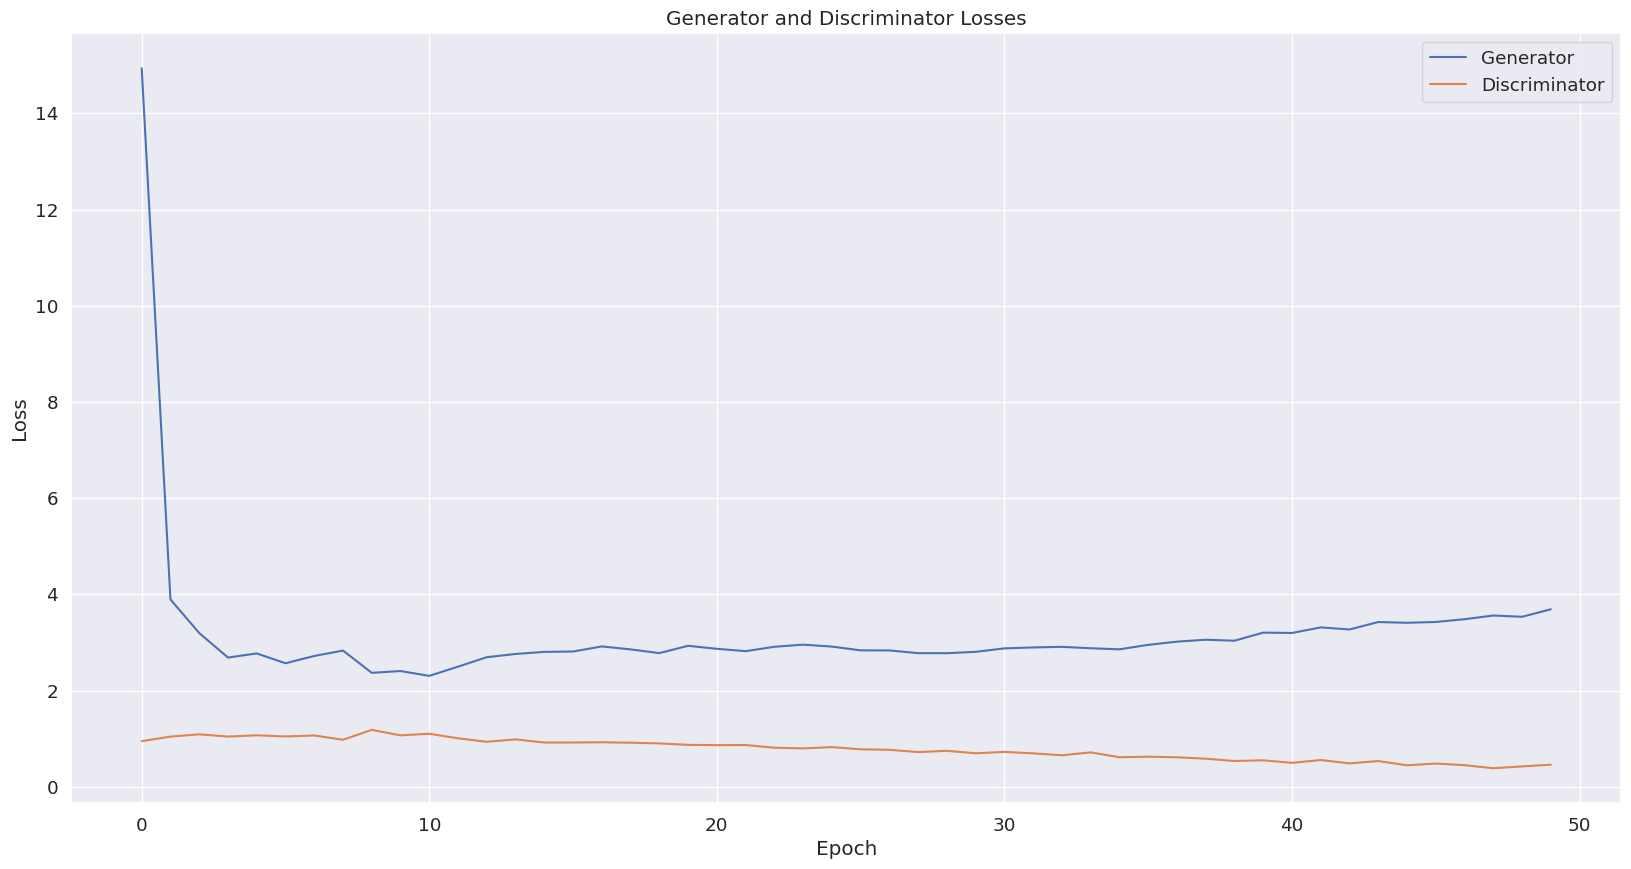

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("Generator and Discriminator Losses")
plt.plot(losses_g, label="Generator")
plt.plot(losses_d, label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

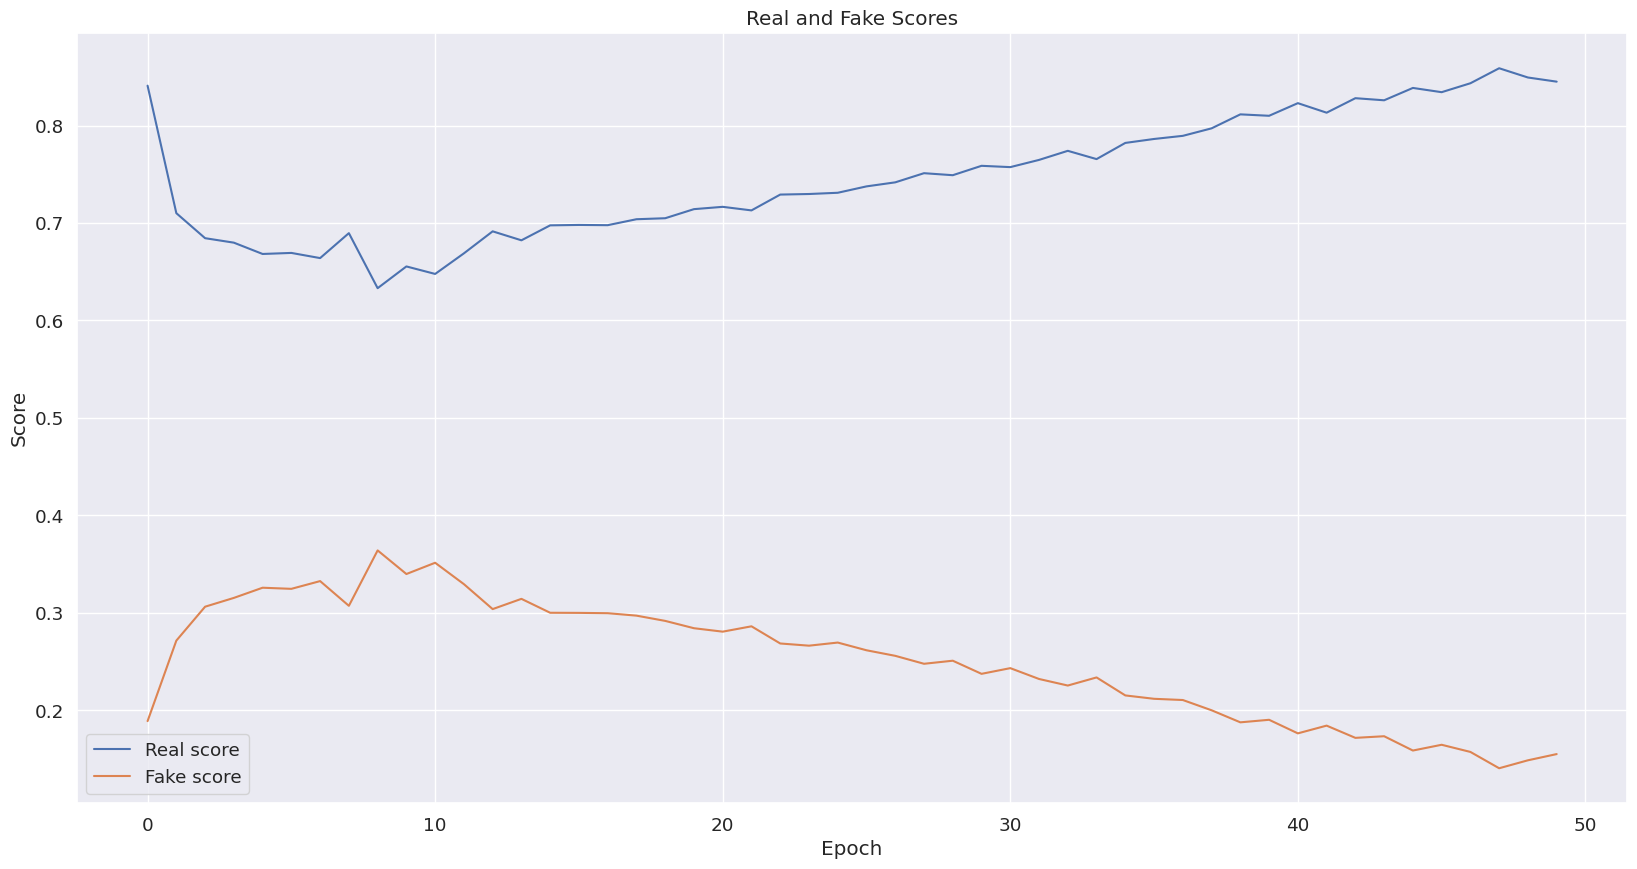

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("Real and Fake Scores")
plt.plot(real_scores, label="Real score")
plt.plot(fake_scores, label="Fake score")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

*Все как на лекции.*

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 32

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
model["generator"].eval()
with torch.no_grad():
    fake_images = model["generator"](fixed_latent).cpu()

In [ ]:
def show_images(images):
    plt.figure(figsize=(20, 20))
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(make_grid(images, padding=5, normalize=True),(1, 2, 0)))

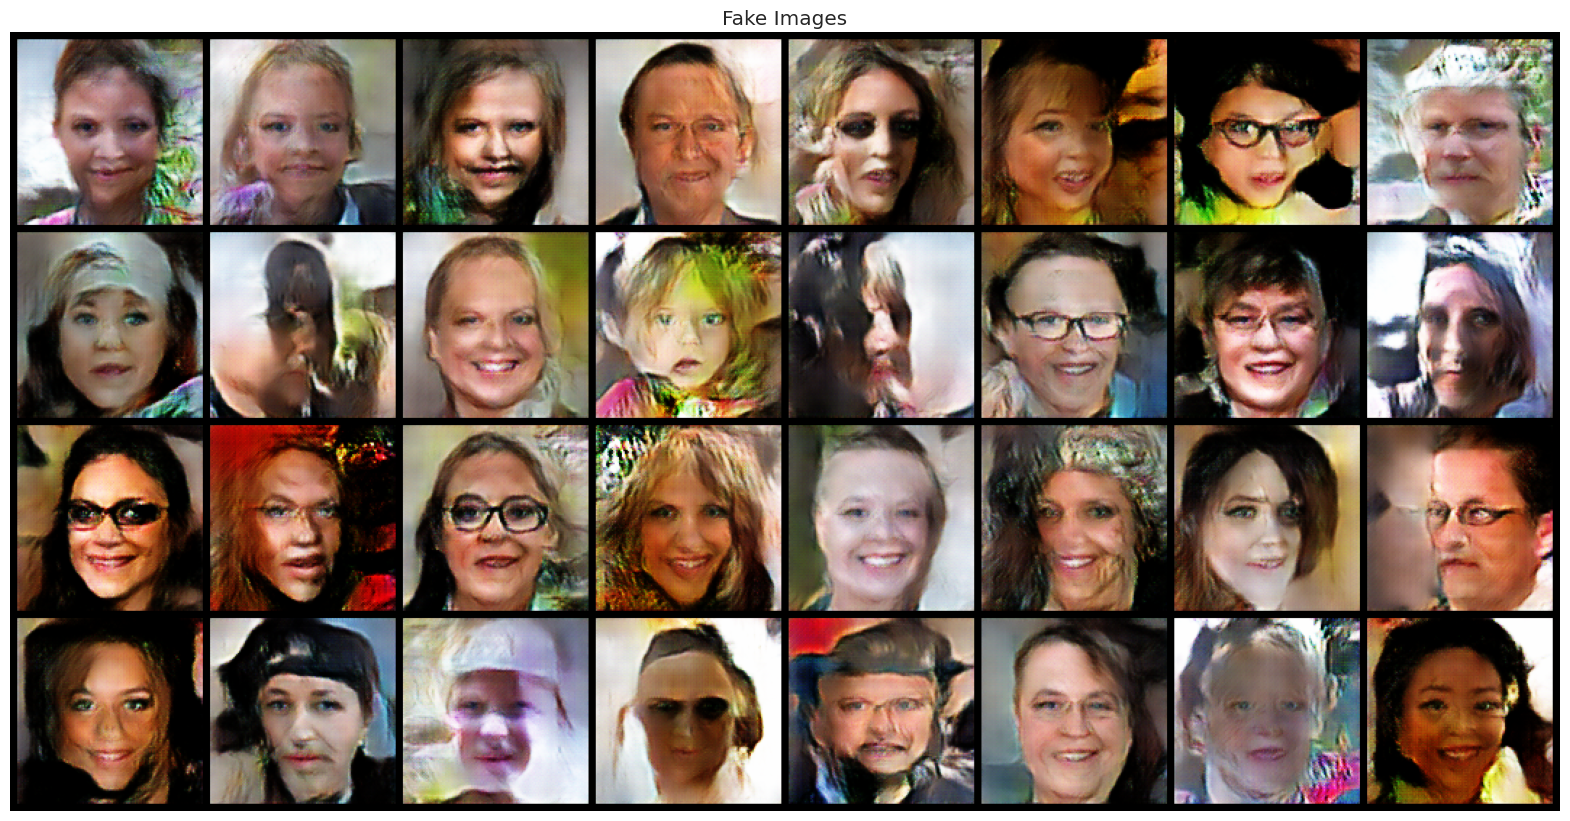

In [ ]:
show_images(fake_images)

Как вам качество получившихся изображений?

*Вполне неплохое, даже умеет генерировать очки и сережки.*

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
# на всем датасете LeaveOneOut работает слишком долго, поэтому возьмем небольшую подвыборку
n_images = 500
assert n_images < len(train_dataset)

In [ ]:
fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)

model["generator"].eval()
with torch.no_grad():
    fake_images = model["generator"](fixed_latent).cpu()

In [ ]:
real_images = []
for idx in tqdm(range(n_images)):
    real_images.append(train_dataset[idx][0])

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
fake_images_reshape = fake_images.reshape(fake_images.shape[0], -1)
real_images_reshape = torch.stack(real_images).reshape(fake_images.shape[0], -1)

In [ ]:
X = torch.concat([fake_images_reshape, real_images_reshape]).numpy()
y = torch.concat((torch.ones(n_images), torch.zeros(n_images))).numpy()

In [ ]:
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=1), X, y, cv=LeaveOneOut())
print(f"LOO score: {cv_scores.mean()}")

LOO score: 0.698


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

*Хотелось бы получить accuracy близкий к 0.5, так как это означало бы, что классификатор не может отличить сгенерированные лица от настоящих. В данном случае accuracy = 0.698 говорит о том, что качество генерации далеко от идеала (это видно по сгенерированным изображениям). Стоит, однако, принять во внимание, что вычисления производились на 500 случайных примерах из датасета и на всем датасете картина может измениться.*

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
from sklearn.manifold import TSNE

reducer = TSNE(n_components=2)
X_reduced = reducer.fit_transform(X)

Прокомментируйте получившийся результат:

In [ ]:
import plotly.express as px

fig = px.scatter(X_reduced, x=0, y=1, color=y.astype(str), labels={'0': 'first-tsne-feature', '1': 'second-tsne-feature'})
fig.show()

Если графика не видно, то вот скриншот из колаба

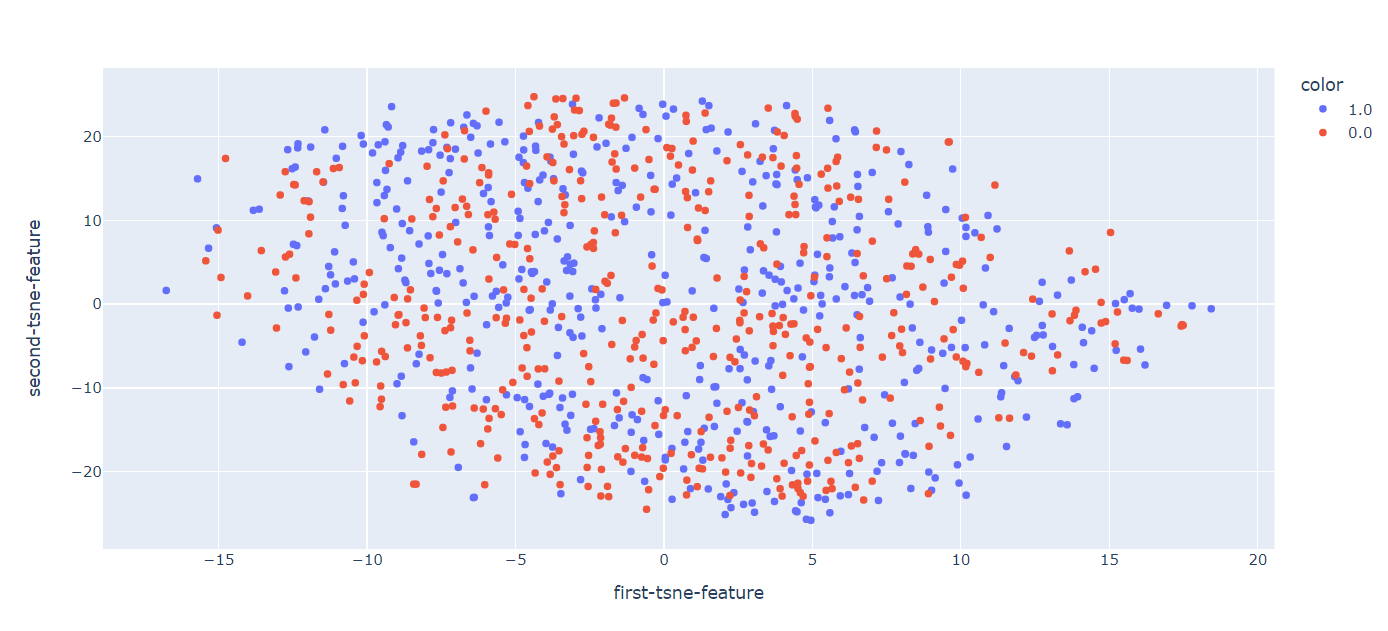

*Распределения настоящих и фейковых изображений оказались очень похожи в двумерном пространстве, что говорит о правильном направлении обучения модели. Присутствуют отдельные скопления точек одного цвета, говорящих нам о том, что отличия между сгенерированными и реальными лицами все еще существенные (это было видно по предыдущим экспериментам).*